In [28]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

import sys
sys.path.append(r"/opt/pyeo")
sen2cor_path = r"/opt/Sen2Cor-02.05.05-Linux64/bin/L2A_Process"
import pyeo.core as pyeo
import joblib
import gdal
import matplotlib.pyplot as plt
pyeo.init_log("training_log.log")

def show_satellite_image(image_path):
    img = gdal.Open(image_path)
    array = img.GetVirtualMemArray()
    if len(array.shape) >= 3:
        img_view = array.transpose([1,2,0])
    else:
        img_view = array
    plt.imshow(img_view)
    img_view = None
    array = None
    img = None


2019-04-10 21:14:54,628: INFO: ****PROCESSING START****


# Step 6

We have an image downloaded now, but we will need a model.

To build a model, we will need training data. This is a list of **classes**, each with associated **features**. For Pyeo, the **features** are pixel values and the **classes** are the change class associated with that pixel.

We have prepared an example training data set, to classify eight classes land use in Brazil. To view this, open sig.csv from the browser.

Each row of this represents a pixel of a certain class. The first value in each row is the class of that pixel, with each value after that being the Sentinel 2 blue, green, red and NIR value of that pixel.

For example, the first row represents class 5, with pixel values of blue = 122.0, green=325.0, red = 254.0 and NIR = 2033.0

To create your own .csv file, you can use ArcGIS 

You can create a scikit-learn Random Forest model using Pyeo with the following function:

```python
pyeo.create_model_from_signatures(
    sig_csv_path,
    model_out_path
)
```

`sig_csv_path` is the path to a .csv file, like sig.csv.

`model_out_path` is where the model will be created.

This creates a model that can be used to classify Sentinel-2 pixels

# Exercise 5: Use sig.csv to create a trained model
**NOTE:** When you save the model, name it (something).pkl

In [4]:
pyeo.create_model_from_signatures("sig.csv", "model.pkl")

# Step 7: Load the model back into Pyeo and explore it

The model we created in step six a Python object, saved as a file. In Python, this is called *pickling*.

To load a pickled object back into Python, use the following snippet:

```python
object = joblib.load("path/to/pickle.pkl")
```
The model you have saved is a Scikit Learn ExtraTreesClassifier object: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

(If most of that page does not make sense to you, do not panic. It doesn't make much sense to me either.)

Normally when you use Pyeo, it handles loading the model for you - see the next step. But knowing how to explore a model if you have been handed it blindly is a very useful skill.

# Exercise 6: Load the model you just created. Using the page above and dir(), find the feature with the most importance to the classification.


In [13]:
model = joblib.load("model.pkl")
model.feature_importances_

array([0.18914861, 0.23764098, 0.24911408, 0.32409633])

## Step 8: Prepare the image you downloaded for classification

Each band in a Sentinel 2 image comes as an individual image. To prepare for classification, Pyeo stacks all relevent bands into a single image, using the following function:

```python
pyeo.stack_sentinel_2_bands(
    safe_dir,
    out_image_path
)
```

By deafult, this stackes every 10m band in the .SAFE dir; bands 2,3,4 and 8A and saves the output at out_image_path.

For example:
```python
pyeo.stack_sentinel_2_bands(
    "images/L2A_MSIL2A_lotsofnumbers.SAFE",
    "images/merged_image.tif"
)
```

will create a four-band geotiff at images/stacked_image.tif

## Exercise 7: Stack the level 2 image you preprocessed yesterday

In [17]:
pyeo.stack_sentinel_2_bands(
    "images/S2B_MSIL2A_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE/",
    "images/merged_image.tif"
)

'images/merged_image.tif'

2019-04-10 21:15:03,505: WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


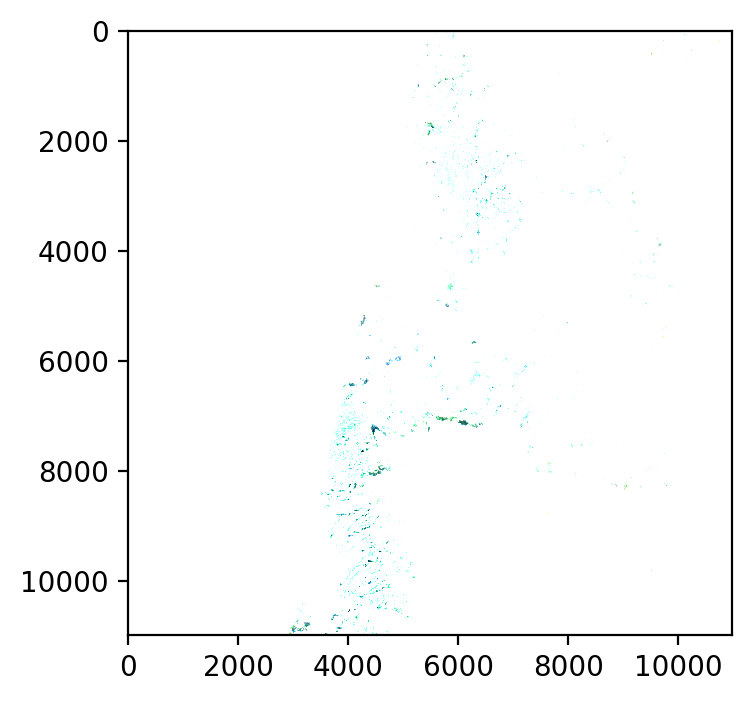

In [29]:
show_satellite_image("images/merged_image.tif")

# Step 9: Classify the image

At last! For this step, the pyeo function you will need is this one:

```python
pyeo.classify_image(
    image_path,
    model_path,
    output_path
)
```

The example:

```python
pyeo.classify_image(
    "images/my_good_image.tif",
    "my_model.pkl",
    "outputs/my_good_outputs.tif"
)
```

will create a raster named my_good_outputs.tif, in the folder outputs

This creates a raster of classes; each pixel is a class.

## Exercise 8: Use pyeo.classify_image to classify the image you stacked in the previous step
This will take betweem 15 and 40 minutes, depending on how many other people are using this machine.
If you want, use `show_satellite_image` to view your output.

In [32]:
pyeo.classify_image(
    "images/merged_image.tif",
    "model.pkl",
    "images/class_image.tif"
)

2019-04-10 21:38:49,017: INFO: Classifying file: images/merged_image.tif
2019-04-10 21:38:49,018: INFO: Saved model     : model.pkl
2019-04-10 21:38:49,019: WARNING: Sklearn joblib import failed,trying generic joblib
2019-04-10 21:38:49,075: INFO: Created classification image file: images/class_image.tif
2019-04-10 21:38:49,079: INFO: Reshaping image from GDAL to Scikit-Learn dimensions
2019-04-10 21:38:49,080: INFO: Finding good pixels without missing values
2019-04-10 21:38:49,080: INFO: image_array.shape = (120560400, 4)
2019-04-10 21:47:16,988: INFO:    All  samples: 120560400
2019-04-10 21:47:16,989: INFO:    Good samples: 75479683
2019-04-10 21:47:17,027: INFO:    Number of chunks 10 Chunk size 7547968 Chunk residual 3
2019-04-10 21:47:17,027: INFO:    Classifying chunk 0 of size 7547968
2019-04-10 21:47:44,927: INFO:    Classifying chunk 1 of size 7547968
2019-04-10 21:48:12,638: INFO:    Classifying chunk 2 of size 7547968
2019-04-10 21:48:41,450: INFO:    Classifying chunk 3 o

'images/class_image.tif'

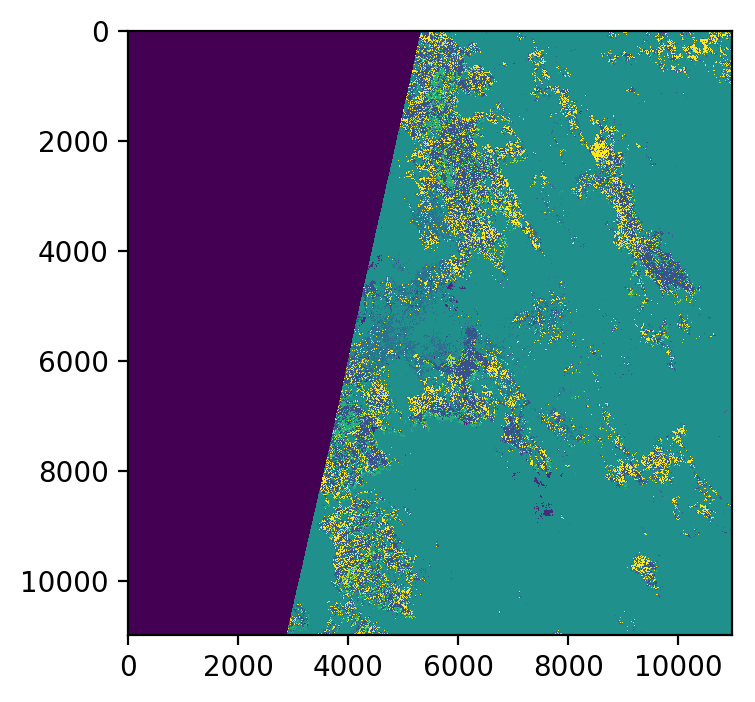

In [33]:
show_satellite_image("images/class_image.tif")

## Step 10: Cloud masking

The image we are using for this practical has a large amount of cloud cover.

We can use a combination of two cloud masking techniques - fmask and sen2cor - to eliminate these clouds from our analysis. To do this, we create a .msk file.

Pyeo makes the assumption that any .msk is the cloudmask for a .tif file with the same name; for example, `merged_image.msk` is the cloudmask for `merged_image.tif`

```python
pyeo.create_mask_from_sen2cor_and_fmask(
    l1_dir,
    l2_dir,
    out_mask_path,
)
```

`l1_dir` and `l2_dir` are the paths to the level 1C and 2A .SAFE files.

Pyeo's masking algorithm requires both level 1 and level 2 Sentinel data; you have to provide paths to both .SAFE files for this function to work.

For example:

```python
pyeo.create_mask_from_sen2cor_and_fmask(
    "S2B_MSIL1C_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE",
    "S2B_MSIL2A_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE",
    "images/merged_image.msk"
)
```

creates a cloudmask for `merged_image.tif` using the two .SAFE files. Note they have **almost** identical names, except for MSIL1C / MSIL2A

The .msk file is just a geotiff with two values; 0 (cloud) and 1 (not cloud).

## Exercise 9: Create a cloudmask for the image you downloaded.
You can view the mask using `show_satellite_image`.

2019-04-10 22:53:32,026: INFO: Creating mask for images/S2B_MSIL2A_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE with 0 confidence threshold
2019-04-10 22:53:34,548: INFO: Mask created at /tmp/tmpp1x_g1jt/s2_mask.tif
2019-04-10 22:53:34,551: INFO: Creating fmask for images/S2B_MSIL1C_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE
2019-04-10 22:53:34,552: INFO: Creating fmask from images/S2B_MSIL1C_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE, output at /tmp/tmpizabjc_d/fmask.tif
2019-04-10 22:56:25,336: INFO: fmask created, converting to binary cloud/shadow mask
2019-04-10 22:56:27,222: INFO: Combining masks ['/tmp/tmpp1x_g1jt/s2_mask.tif', '/tmp/tmpp1x_g1jt/fmask.tif']:
   combination function: 'and'
   geometry function:'union'


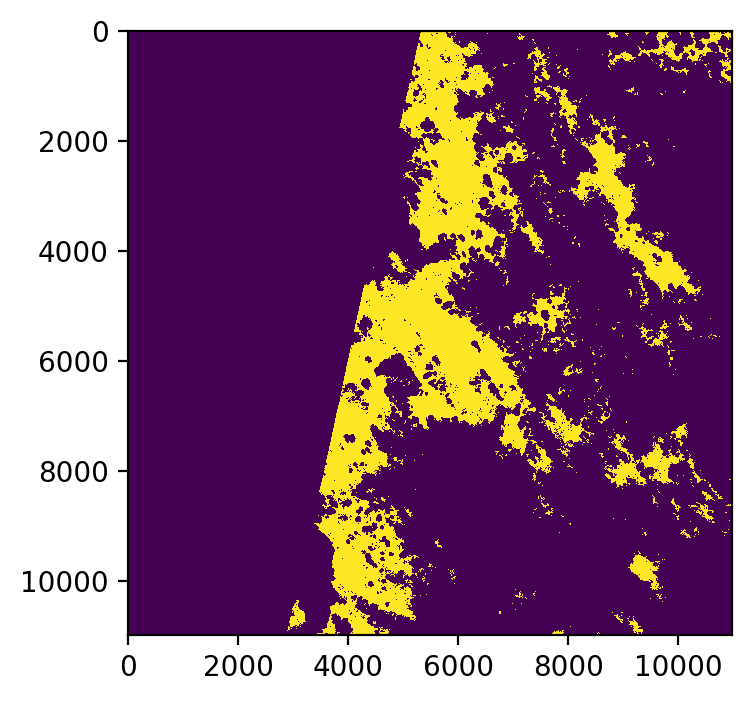

In [36]:
pyeo.create_mask_from_sen2cor_and_fmask(
    "images/S2B_MSIL1C_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE",
    "images/S2B_MSIL2A_20190104T074319_N0207_R092_T36MZE_20190104T095459.SAFE",
    "images/merged_image.msk"
)
show_satellite_image("images/merged_image.msk")

## Step 11: Classify using the mask

`pyeo.classify_image` has an extra option. If you add the augment use_mask=True, Pyeo will look for a .msk corresponding to the .tif you want to classify:

```python
pyeo.classify_image(
    image_path,
    model_path,
    output_path,
    apply_mask=True
)
```

## Exercise 10: Re-run classify_image with `apply_mask = True.`

In [40]:
pyeo.classify_image(
    "images/merged_image.tif",
    "model.pkl",
    "images/class_image.tif",
    apply_mask = True
)

2019-04-10 23:14:37,565: INFO: Classifying file: images/merged_image.tif
2019-04-10 23:14:37,566: INFO: Saved model     : model.pkl
2019-04-10 23:14:37,567: WARNING: Sklearn joblib import failed,trying generic joblib
2019-04-10 23:14:37,634: INFO: Created classification image file: images/class_image.tif
2019-04-10 23:14:37,639: INFO: Applying mask at images/merged_image.msk
2019-04-10 23:14:43,147: INFO: Reshaping image from GDAL to Scikit-Learn dimensions
2019-04-10 23:14:43,148: INFO: Finding good pixels without missing values
2019-04-10 23:14:43,148: INFO: image_array.shape = (120560400, 4)
2019-04-10 23:21:54,087: INFO:    All  samples: 120560400
2019-04-10 23:21:54,088: INFO:    Good samples: 18799764
2019-04-10 23:21:54,091: INFO:    Number of chunks 10 Chunk size 1879976 Chunk residual 4
2019-04-10 23:21:54,092: INFO:    Classifying chunk 0 of size 1879976
2019-04-10 23:22:03,188: INFO:    Classifying chunk 1 of size 1879976
2019-04-10 23:22:12,196: INFO:    Classifying chunk 2

'images/class_image.tif'

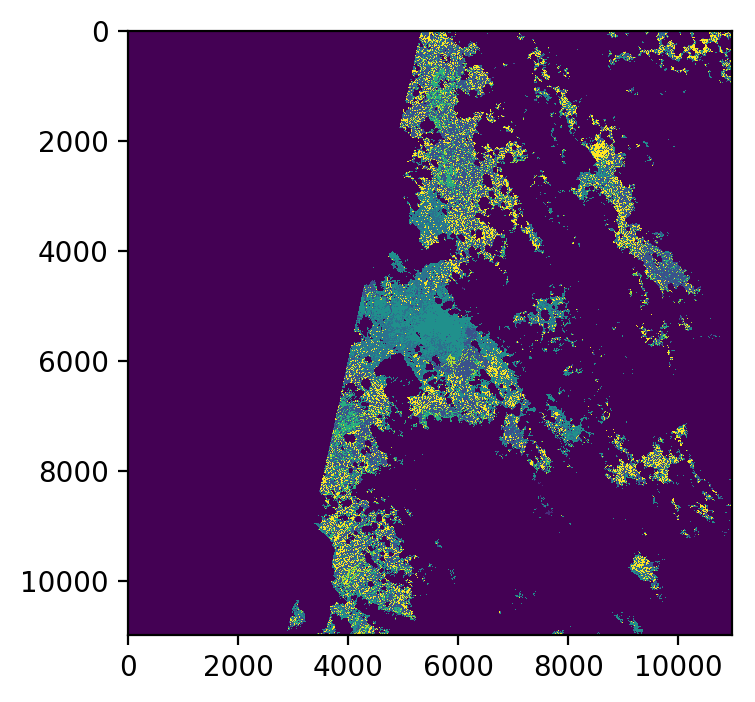

In [42]:
show_satellite_image("images/class_image.tif")

Congratulations; you have downloaded, preprocessed, masked and classified a Sentinel 2 image using Pyeo.

There are a number of helper functions in Pyeo to make performing these actions on large amounts of data easier. Each of the functions you have called in this training session are wrapped in functions that call them on entire directories of images at a time; for example `atmospheric_correction(in_dir, out_dir, sen2cor_path)` calls Sen2Cor on every image in in_dir and saves each of the results in out_dir. Similarly, `preprocess_s2_data(in_dir, out_dir, epsg)` wraps steps 8 and 9 together, along with an optional step to reproject to an EPSG of your choice.

# Further exercise: change detection

There are many methods of change detection. The one we favour in Leicester at present is this:

* Stack two images together to form an 8 band image (old BGRI, new BGRI)
* Classify this using a model trained on 8 features per class

When you have reached this step, let an instructor know and we will provide you wil a pre-trained model. Using what you have learned in this workshop, along with the following pyeo function that stacks an old and a new image into a single geotif:

```python
pyeo.stack_old_and_new_images(
    old_image_path,
    new_image_path,
    out_dir,
    create_combined_mask=True,
)
```

Classify change between your two images.

You will need to download and preprocess another image from the Kinangop region.
Good luck!

In [41]:
?pyeo.stack_old_and_new_images